[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mifumo081a/pytorch_template/blob/main/examples/notebooks/mnist.ipynb)


In [1]:
!git clone https://github.com/mifumo081a/pytorch_template.git
!ls

Cloning into 'pytorch_template'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 26 (delta 1), reused 26 (delta 1), pack-reused 0
Unpacking objects: 100% (26/26), done.
pytorch_template  sample_data


In [3]:
!pip install -r pytorch_template/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
import os
import torchinfo

In [5]:
import pytorch_template.cross_varidation as cv
from pytorch_template.utils import *
from pytorch_template.trainer import Trainer_Classifier

In [6]:
root = os.getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRAIN =True

In [7]:
logs_root = os.path.join(root, "logs/", "mnist/")
os.makedirs(logs_root, exist_ok=True)

In [8]:
trainval_dataset = datasets.MNIST(os.path.join(root, "data/"), train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(os.path.join(root, "data/"), train=False, download=True, transform=transforms.ToTensor())

trainval_dataset.labels = [str(i) for i in range(10)]
test_dataset.labels  = [str(i) for i in range(10)]

transforms_dict = {"train": 
                   transforms.Compose([
                       transforms.ToTensor()
                       ]),
                   "val":
                    transforms.Compose([
                       transforms.ToTensor()
                       ]),
                   "test":
                   transforms.Compose([
                       transforms.ToTensor()
                       ])
}

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw



In [9]:
num_workers = os.cpu_count()
n_splits = 5
batch_size = 50
if TRAIN:
    kfold_root = cv.kfold_split(dataset=trainval_dataset, test_dataset=test_dataset, transforms=transforms_dict, n_splits=n_splits,
                                root=root, num_workers=num_workers, batch_size=batch_size)
else:
    os.path.join(root, "kfold_pickle")
print(kfold_root)

Train: 48000, Val: 12000
Train: 48000, Val: 12000
Train: 48000, Val: 12000
Train: 48000, Val: 12000
Train: 48000, Val: 12000
Test: 10000
All: 70000
/content/kfold_pickle


# Model initialize and Train

In [14]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = models.vgg16(pretrained=True).features[:10]
        for layer in self.features:
            for param in layer.parameters():
                param.requires_grad = False
        # self.avgpool = models.vgg16().avgpool
        self.classifier = nn.Sequential(
            nn.Linear(128, 10),
            nn.Sigmoid(),
        )
        
    def forward(self,x):
        x = x.repeat(1, 3, 1, 1)
        fmaps = self.features(x)
        # global average pooling
        x = fmaps.mean([2,3])
        x = self.classifier(x)
        
        return x, fmaps

torchinfo.summary(Model(), (1, 1, 28, 28))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 128, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 28, 28]           (1,792)
│    └─ReLU: 2-2                         [1, 64, 28, 28]           --
│    └─Conv2d: 2-3                       [1, 64, 28, 28]           (36,928)
│    └─ReLU: 2-4                         [1, 64, 28, 28]           --
│    └─MaxPool2d: 2-5                    [1, 64, 14, 14]           --
│    └─Conv2d: 2-6                       [1, 128, 14, 14]          (73,856)
│    └─ReLU: 2-7                         [1, 128, 14, 14]          --
│    └─Conv2d: 2-8                       [1, 128, 14, 14]          (147,584)
│    └─ReLU: 2-9                         [1, 128, 14, 14]          --
│    └─MaxPool2d: 2-10                   [1, 128, 7, 7]            --
├─Sequential: 1-2                        [1, 10]             

In [15]:
model_root = os.path.join(root, "models/")
print(model_root)
if TRAIN:
    set_model(model=Model(), model_root=model_root)

/content/models/


In [16]:
if TRAIN:
  trainer_list = []
  for k in range(n_splits):
    path = os.path.join(kfold_root, str(k)+"/")
    trainer_list.append(
        Trainer_Classifier(model=get_model("nontrain", model_root, device),
                           device=device,
                           dataloaders=get_dataloaders(path),
                           epochs=10)
    )

/content/models/nontrain.pkl
/content/kfold_pickle/0/dataloaders.pkl
/content/models/nontrain.pkl
/content/kfold_pickle/1/dataloaders.pkl
/content/models/nontrain.pkl
/content/kfold_pickle/2/dataloaders.pkl
/content/models/nontrain.pkl
/content/kfold_pickle/3/dataloaders.pkl
/content/models/nontrain.pkl
/content/kfold_pickle/4/dataloaders.pkl


In [17]:
if TRAIN:
    cv.kfold_train(save_model_root=model_root, n_splits=n_splits,
                   trainer_list=trainer_list)

Pattern:  0


[Epoch10/10]: 100%|██████████| 10/10 [01:36<00:00,  9.61s/it, Loss=1.61, Acc=0.922]


Best val Loss: 1.6125
Acc: 0.9221 
Pattern:  1


[Epoch10/10]: 100%|██████████| 10/10 [01:36<00:00,  9.60s/it, Loss=1.61, Acc=0.918]


Best val Loss: 1.6143
Acc: 0.9177 
Pattern:  2


[Epoch10/10]: 100%|██████████| 10/10 [01:35<00:00,  9.54s/it, Loss=1.61, Acc=0.916]


Best val Loss: 1.6139
Acc: 0.9159 
Pattern:  3


[Epoch10/10]: 100%|██████████| 10/10 [01:35<00:00,  9.56s/it, Loss=1.61, Acc=0.923]


Best val Loss: 1.6129
Acc: 0.9227 
Pattern:  4


[Epoch10/10]: 100%|██████████| 10/10 [01:34<00:00,  9.45s/it, Loss=1.61, Acc=0.927]

Best val Loss: 1.6070
Acc: 0.9275 


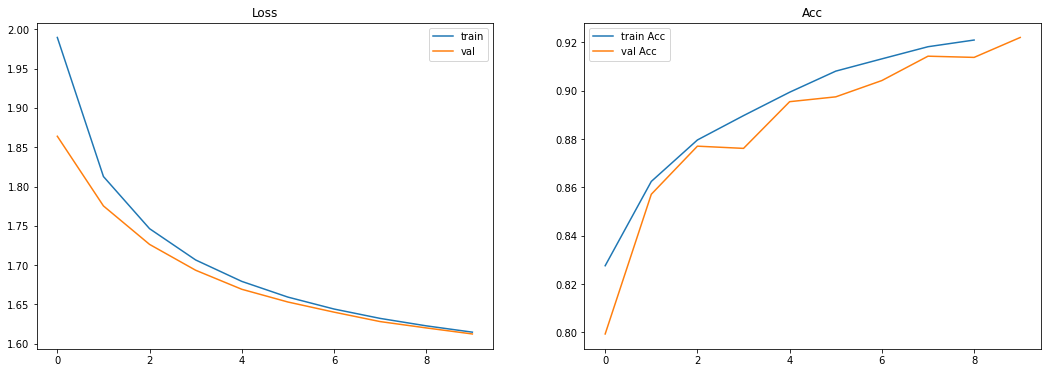

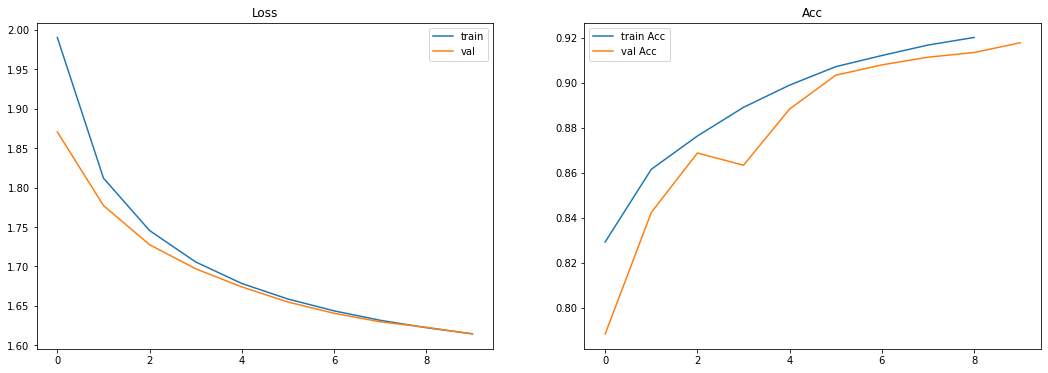

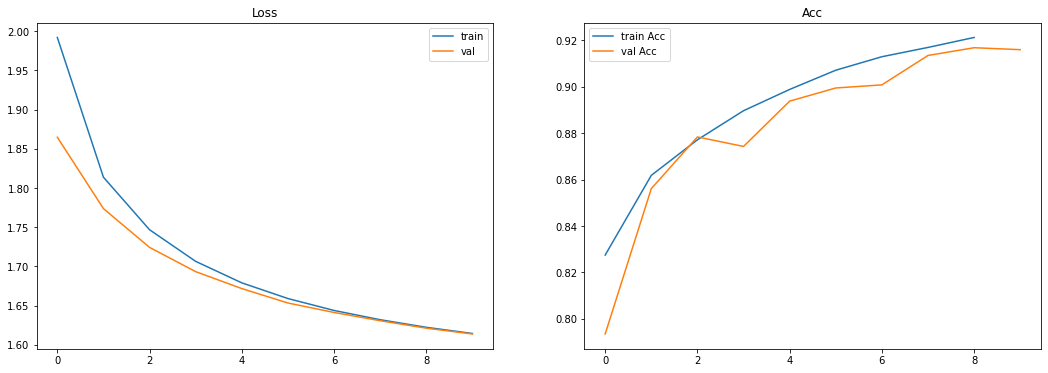

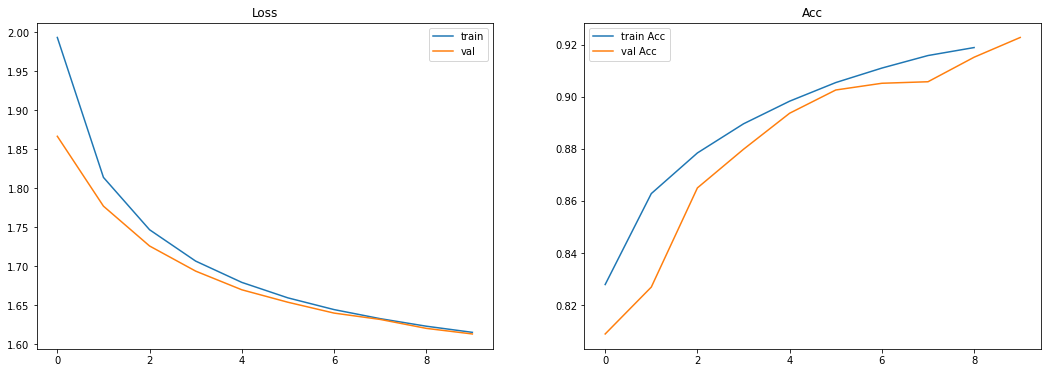

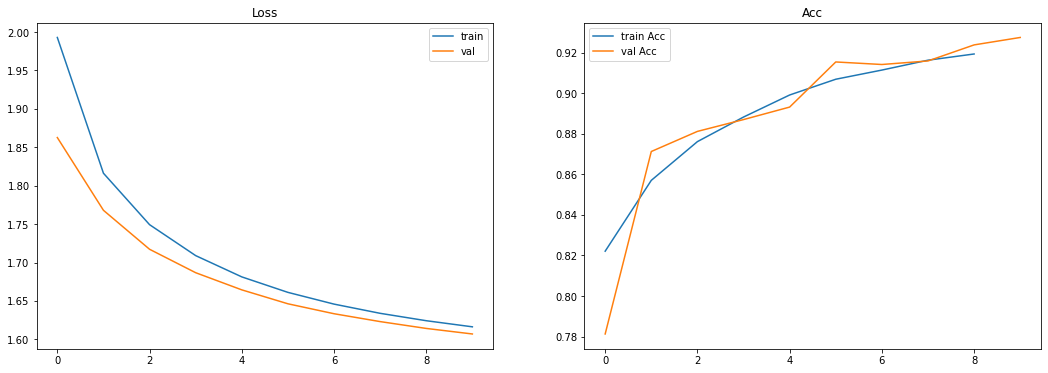

In [18]:
if TRAIN:
    for k in range(n_splits):
        path = os.path.join(kfold_root, str(k)+"/")
        trainer_list[k].show_curve(logs_root=os.path.join
                                   (logs_root, "curves/"), fname=str(k), save=False)

# Evaluate models

In [19]:
from pytorch_template.evaluator import ImageClassifier_Evaluator

In [20]:
evaluator_list = []
for k in range(n_splits):
    dataloader_path = os.path.join(kfold_root, str(k)+"/")
    model_path = os.path.join(model_root, str(k)+"/")
    print(dataloader_path, model_path)
    evaluator_list.append(ImageClassifier_Evaluator(model=get_model("model_fit", model_path, device),
                                          device=device,
                                          dataloaders=get_dataloaders(dataloader_path),
                                          testloaders=get_testloaders(kfold_root),
                                          logs_root=logs_root
                                         )
                         )

/content/kfold_pickle/0/ /content/models/0/
/content/models/0/model_fit.pkl
/content/kfold_pickle/0/dataloaders.pkl
/content/kfold_pickle/testloaders.pkl
/content/kfold_pickle/1/ /content/models/1/
/content/models/1/model_fit.pkl
/content/kfold_pickle/1/dataloaders.pkl
/content/kfold_pickle/testloaders.pkl
/content/kfold_pickle/2/ /content/models/2/
/content/models/2/model_fit.pkl
/content/kfold_pickle/2/dataloaders.pkl
/content/kfold_pickle/testloaders.pkl
/content/kfold_pickle/3/ /content/models/3/
/content/models/3/model_fit.pkl
/content/kfold_pickle/3/dataloaders.pkl
/content/kfold_pickle/testloaders.pkl
/content/kfold_pickle/4/ /content/models/4/
/content/models/4/model_fit.pkl
/content/kfold_pickle/4/dataloaders.pkl
/content/kfold_pickle/testloaders.pkl


              precision    recall  f1-score   support

           0       0.94      0.95      0.94       980
           1       0.98      0.99      0.98      1135
           2       0.90      0.86      0.88      1032
           3       0.95      0.93      0.94      1010
           4       0.93      0.95      0.94       982
           5       0.84      0.92      0.88       892
           6       0.96      0.92      0.94       958
           7       0.94      0.93      0.93      1028
           8       0.94      0.91      0.93       974
           9       0.89      0.91      0.90      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



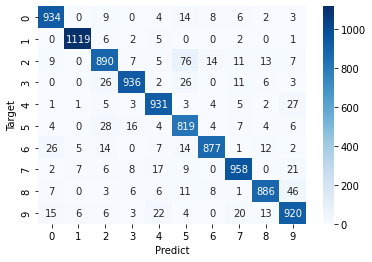

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       980
           1       0.99      0.98      0.98      1135
           2       0.87      0.87      0.87      1032
           3       0.96      0.92      0.94      1010
           4       0.89      0.96      0.93       982
           5       0.84      0.91      0.87       892
           6       0.96      0.91      0.93       958
           7       0.97      0.88      0.92      1028
           8       0.94      0.93      0.93       974
           9       0.89      0.92      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.92      0.92     10000



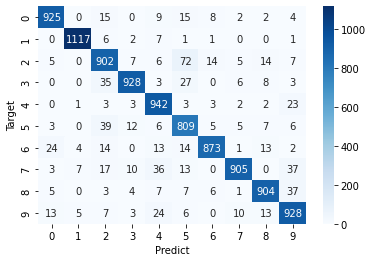

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       980
           1       0.98      0.99      0.98      1135
           2       0.88      0.84      0.86      1032
           3       0.96      0.91      0.93      1010
           4       0.92      0.96      0.94       982
           5       0.79      0.94      0.86       892
           6       0.96      0.91      0.93       958
           7       0.96      0.90      0.93      1028
           8       0.94      0.93      0.94       974
           9       0.92      0.90      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.92      0.92     10000



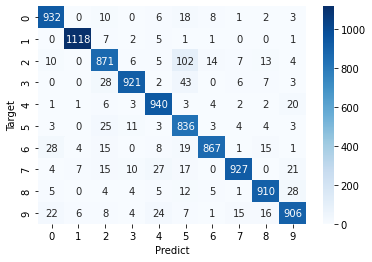

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       980
           1       0.99      0.98      0.99      1135
           2       0.90      0.85      0.88      1032
           3       0.93      0.95      0.94      1010
           4       0.92      0.95      0.94       982
           5       0.84      0.90      0.87       892
           6       0.94      0.93      0.93       958
           7       0.96      0.90      0.93      1028
           8       0.94      0.93      0.94       974
           9       0.92      0.90      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



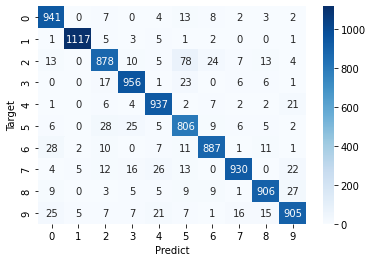

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       980
           1       0.99      0.99      0.99      1135
           2       0.88      0.87      0.88      1032
           3       0.92      0.95      0.94      1010
           4       0.91      0.96      0.93       982
           5       0.84      0.90      0.87       892
           6       0.95      0.93      0.94       958
           7       0.96      0.90      0.93      1028
           8       0.95      0.93      0.94       974
           9       0.91      0.90      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



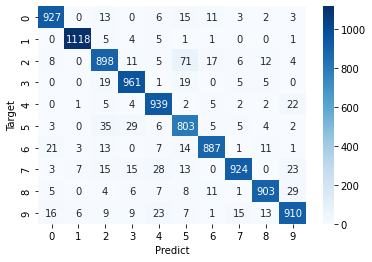

In [25]:
kfold_acc = []
for k in range(n_splits):
    evaluator_list[k].confusion_matrix(folder_name="confusion_matrix", fname=str(k), save=False)
    kfold_acc.append(evaluator_list[k].acc)

In [26]:
print("Acc mean: {:.4f}, std: {:.4f}".format(np.array(kfold_acc).mean(), np.array(kfold_acc).std()))

Acc mean: 0.9253, std: 0.0018


In [27]:
for k in range(n_splits):
    evaluator_list[k].show_scores(folder_name="eval", fname=str(k), save=False)

Accuracy: 0.9270
F scores: (0: 0.9444)(1: 0.9846)(2: 0.8790)(3: 0.9402)(4: 0.9380)(5: 0.8769)(6: 0.9365)(7: 0.9346)(8: 0.9268)(9: 0.8998)
Recalls: (0: 0.9531)(1: 0.9859)(2: 0.8624)(3: 0.9267)(4: 0.9481)(5: 0.9182)(6: 0.9154)(7: 0.9319)(8: 0.9097)(9: 0.9118)
Precisions: (0: 0.9359)(1: 0.9833)(2: 0.8963)(3: 0.9541)(4: 0.9282)(5: 0.8391)(6: 0.9585)(7: 0.9374)(8: 0.9446)(9: 0.8880)
Accuracy: 0.9233
F scores: (0: 0.9448)(1: 0.9846)(2: 0.8702)(3: 0.9378)(4: 0.9258)(5: 0.8704)(6: 0.9347)(7: 0.9211)(8: 0.9334)(9: 0.9023)
Recalls: (0: 0.9439)(1: 0.9841)(2: 0.8740)(3: 0.9188)(4: 0.9593)(5: 0.9070)(6: 0.9113)(7: 0.8804)(8: 0.9281)(9: 0.9197)
Precisions: (0: 0.9458)(1: 0.9850)(2: 0.8665)(3: 0.9577)(4: 0.8946)(5: 0.8366)(6: 0.9593)(7: 0.9658)(8: 0.9387)(9: 0.8855)
Accuracy: 0.9228
F scores: (0: 0.9390)(1: 0.9846)(2: 0.8619)(3: 0.9346)(4: 0.9367)(5: 0.8574)(6: 0.9318)(7: 0.9307)(8: 0.9367)(9: 0.9065)
Recalls: (0: 0.9510)(1: 0.9850)(2: 0.8440)(3: 0.9119)(4: 0.9572)(5: 0.9372)(6: 0.9050)(7: 0.9018)(8:

Classified as  9 , model output = tensor([3.0864e-03, 3.9708e-04, 3.8831e-03, 2.8702e-03, 2.8903e-03, 2.2219e-03,
        1.1193e-02, 3.6667e-01, 5.9705e-03, 9.8803e-01], device='cuda:0')
9 ( 9 ) 22.09 %
7 ( 7 ) 11.86 %
6 ( 6 ) 8.32 %
8 ( 8 ) 8.27 %
2 ( 2 ) 8.25 %
0 ( 0 ) 8.25 %
4 ( 4 ) 8.25 %
3 ( 3 ) 8.25 %
5 ( 5 ) 8.24 %
1 ( 1 ) 8.23 %


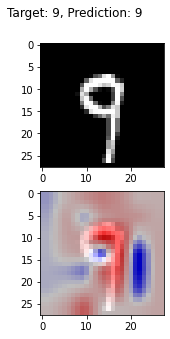

Classified as  1 , model output = tensor([0.0037, 0.9995, 0.0060, 0.0958, 0.0218, 0.0550, 0.0065, 0.0210, 0.0028,
        0.2363], device='cuda:0')
1 ( 1 ) 22.26 %
9 ( 9 ) 10.38 %
3 ( 3 ) 9.02 %
5 ( 5 ) 8.66 %
4 ( 4 ) 8.38 %
7 ( 7 ) 8.37 %
6 ( 6 ) 8.25 %
2 ( 2 ) 8.24 %
0 ( 0 ) 8.23 %
8 ( 8 ) 8.22 %


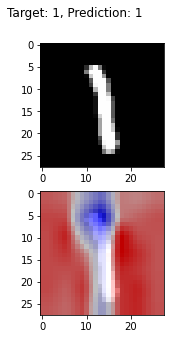

Classified as  2 , model output = tensor([1.1689e-03, 2.4743e-09, 9.9489e-01, 2.1724e-02, 1.3173e-02, 5.9516e-02,
        1.2028e-01, 1.0912e-04, 4.5684e-02, 1.3944e-02], device='cuda:0')
2 ( 2 ) 22.55 %
6 ( 6 ) 9.41 %
5 ( 5 ) 8.85 %
8 ( 8 ) 8.73 %
3 ( 3 ) 8.52 %
9 ( 9 ) 8.46 %
4 ( 4 ) 8.45 %
0 ( 0 ) 8.35 %
7 ( 7 ) 8.34 %
1 ( 1 ) 8.34 %


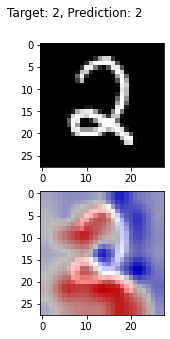

Classified as  8 , model output = tensor([1.1865e-04, 4.8791e-06, 1.7636e-02, 3.4433e-01, 5.2301e-02, 3.4081e-03,
        3.1368e-01, 9.6140e-05, 9.5006e-01, 8.4698e-01], device='cuda:0')
8 ( 8 ) 18.77 %
9 ( 9 ) 16.94 %
3 ( 3 ) 10.24 %
6 ( 6 ) 9.94 %
4 ( 4 ) 7.65 %
2 ( 2 ) 7.39 %
5 ( 5 ) 7.29 %
0 ( 0 ) 7.26 %
7 ( 7 ) 7.26 %
1 ( 1 ) 7.26 %


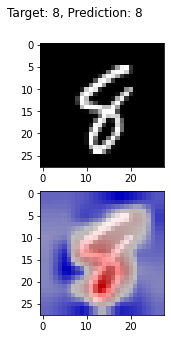

Classified as  1 , model output = tensor([6.5129e-02, 9.9971e-01, 1.6863e-02, 1.1823e-04, 2.5026e-02, 9.9039e-03,
        2.0849e-01, 1.6896e-01, 4.4901e-05, 2.4323e-03], device='cuda:0')
1 ( 1 ) 22.17 %
6 ( 6 ) 10.05 %
7 ( 7 ) 9.66 %
0 ( 0 ) 8.71 %
4 ( 4 ) 8.37 %
2 ( 2 ) 8.30 %
5 ( 5 ) 8.24 %
9 ( 9 ) 8.18 %
3 ( 3 ) 8.16 %
8 ( 8 ) 8.16 %


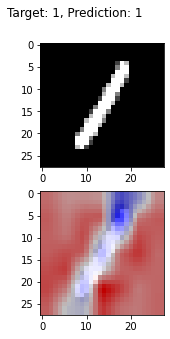

In [28]:
for k in range(n_splits):
    evaluator_list[k].show_cam(folder_name="cam", fname=str(k), save=False)